# Class 24: Spatial Data, OSMNX, GeoPandas

Goal of today's class:
1. Introduce shapefiles
2. Introduce `geopandas` for spatial tasks
3. Integrate what we learned with `osmnx`

__________

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/phys7332-env/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

## Introduction: Random Geometric Graphs

Random geometric graphs (RGGs) are spatially-embedded networks where the probability $p_{ij}$ that any pair of nodes is connected is a function of the distance between $i$ and $j$. RGGs differ from classical random graphs (e.g., Erdős-Rényi graphs) by embedding nodes in space, imposing locality constraints on edge formation. This makes RGGs particularly useful for studying networks with spatial dependencies. This paradigm is useful for studying systems ranging from wireless communication networks, to transportation systems, to certain biological networks (e.g. physical connections between neurons in a brain). 

A simple example of this is an RGG with $N$ nodes, each of which are connected if they are within a given radius, $r$, of each other. These nodes are embedded on a unit square or cube with Euclidean distance, but other spaces (e.g., toroidal, hyperbolic) can also be used. 


### Applications of RGGs

1. **Wireless Networks**
   - Nodes represent devices, and edges represent communication links. The radius \(r\) models signal range.
   - Analyze network robustness or connectivity under varying radii.

2. **Transportation Networks**
   - Nodes as cities or hubs, edges based on geographic proximity.
   - Study efficient routing or identify vulnerable regions.

3. **Social Networks**
   - Nodes as individuals in a physical space, edges based on interaction likelihood.
   - Explore clustering patterns in real-world social systems.


**References**

1. Penrose, M. D. (2003). *Random Geometric Graphs.* Oxford University Press. https://doi.org/10.1093/acprof:oso/9780198506263.001.0001
2. Gilbert, E. N. (1961). Random plane networks. *Journal of the Society for Industrial and Applied Mathematics*, 9(4), 533–543. https://doi.org/10.1137/0109045
3. Dall, J., & Christensen, M. (2002). Random geometric graphs. *Physical Review E*, 66(1), 016121. https://doi.org/10.1103/PhysRevE.66.016121
4. Penrose, M. D. (1999). On $k$-connectivity for a geometric random graph. *Random Structures & Algorithms*, 15(2), 145–164. https://doi.org/10.1002/(SICI)1098-2418(199909)15:2%3C145::AID-RSA2%3E3.0.CO;2-G
5. Barthelemy, M. (2011). Spatial networks. *Physics Reports*, 499(1–3), 1–101. https://doi.org/10.1016/j.physrep.2010.11.002
6. Haenggi, M. (2009). *Stochastic Geometry for Wireless Networks.* Cambridge University Press. https://doi.org/10.1017/CBO9781139043816
7. Eppstein, D., Goodrich, M. T., & Trott, L. (2009, November). Going off-road: transversal complexity in road networks. In Proceedings of the 17th *ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems* (pp. 23-32). https://doi.org/10.1145/1653771.1653778

### Creating an RGG in Python

In [2]:
np.random.seed(5)
N = 100
r = 0.19 # Connection radius

# Randomly place nodes in a unit square
positions = np.random.rand(N, 2)

In [3]:
# Create the graph
G = nx.Graph()
G.add_nodes_from(list(range(N)))
pos = dict(zip(G.nodes(),positions))

In [4]:
# Add edges based on Euclidean distance
for i in range(N):
    for j in range(i + 1, N):
        distance = np.linalg.norm(positions[i] - positions[j])
        if distance <= r:
            G.add_edge(i, j)

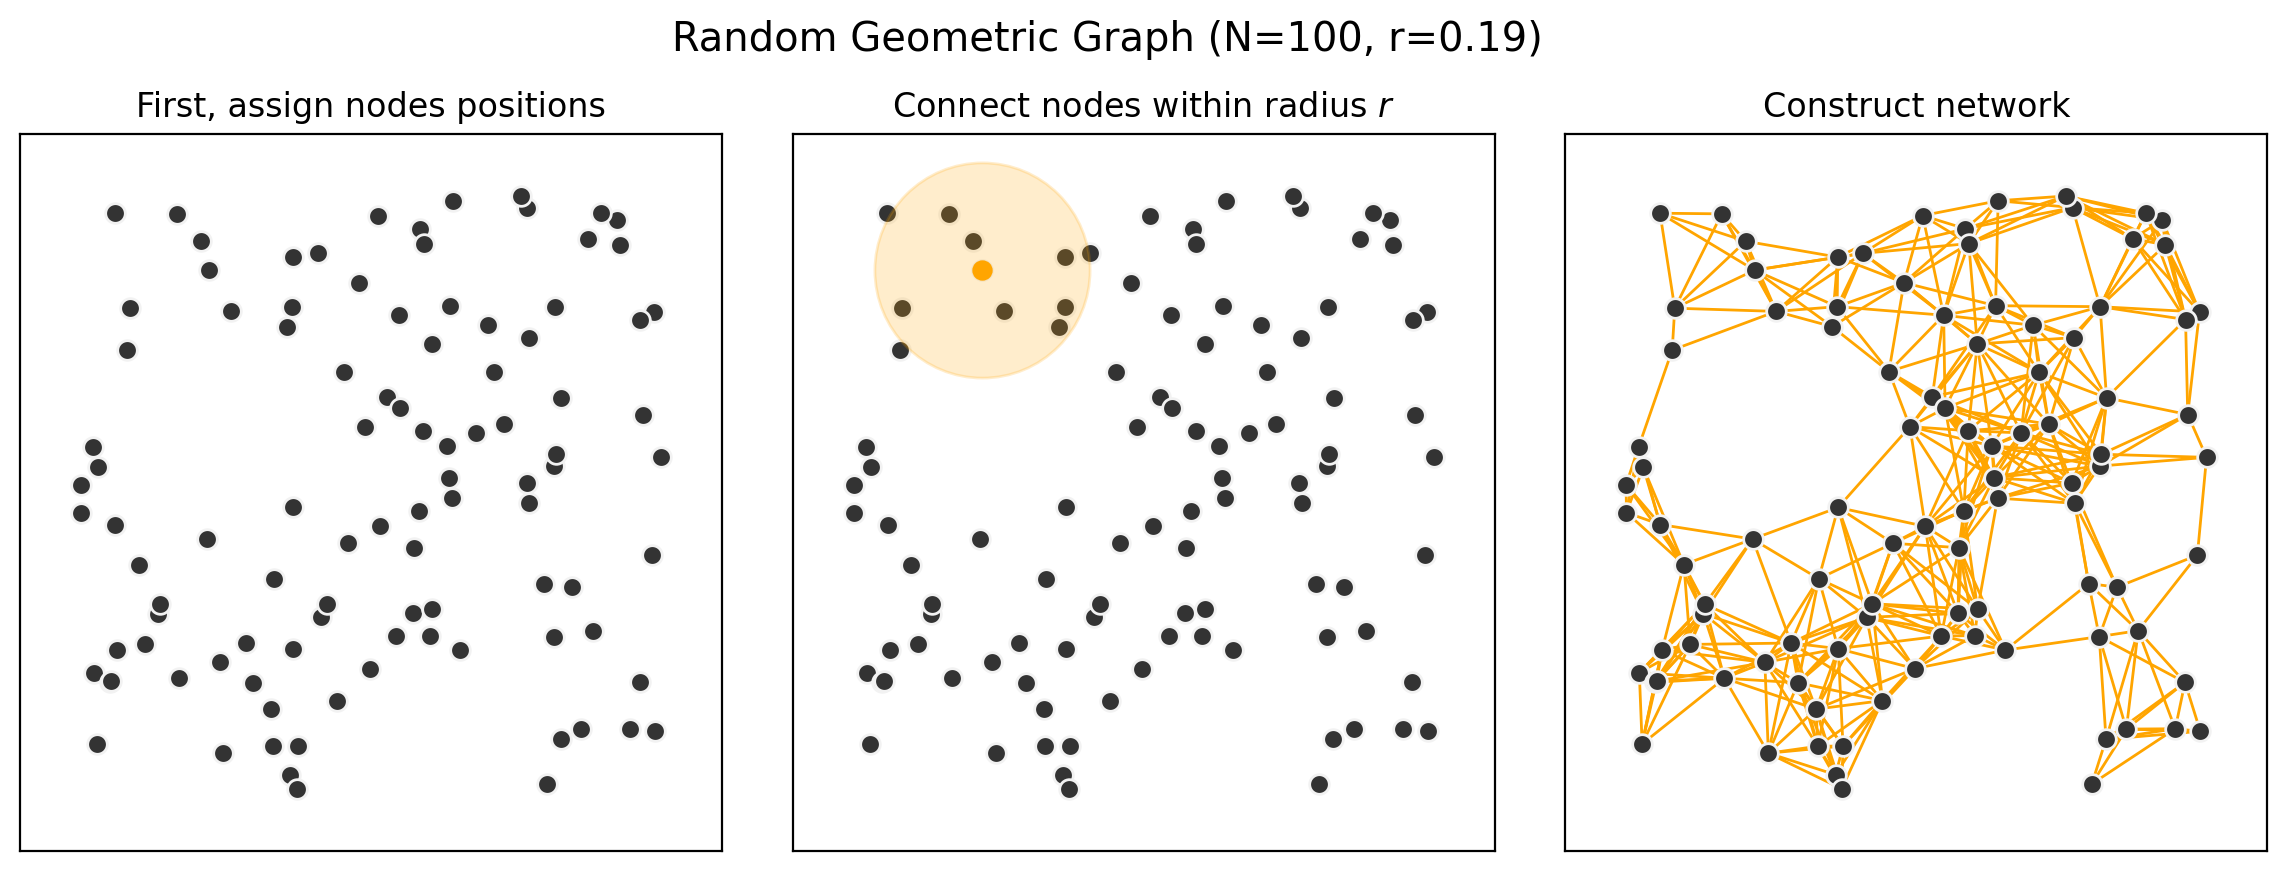

In [5]:
fig, ax = plt.subplots(1,3,figsize=(14.5,4.75),dpi=200,sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1)

# First
nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax[0], node_color='.2', edgecolors='.95')

# Second
nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax[1], node_color='.2', edgecolors='.95')
ax[1].scatter(positions[:,0][:1],positions[:,1][:1], s=40, color='orange', zorder=201)
ax[1].scatter(positions[:,0][:1],positions[:,1][:1], alpha=0.2, s=6000, color='orange', zorder=200)

# Third
nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax[2], node_color='.2', edgecolors='.95')
nx.draw_networkx_edges(G, pos, edge_color='orange', ax=ax[2])

ax[0].set_title('First, assign nodes positions')
ax[1].set_title('Connect nodes within radius $r$')
ax[2].set_title('Construct network')


plt.suptitle("Random Geometric Graph (N=%i, r=%.2f)"%(N,r),fontsize='x-large',y=1)


plt.show()

____
### Key Properties of RGGs
1. An important question in RGGs is the relationship between the connectivity radius $r$ and the number of nodes $n$. For a graph to be fully connected: $ r \propto \sqrt{\frac{\log n}{n}} $. This ensures that, as $n$ increases, the probability of the graph being connected approaches 1.

2. The clustering coefficient of an RGG tends to be high because nodes are connected based on spatial proximity, leading to local clusters. This is a distinguishing feature compared to random graphs like Erdős–Rényi graphs, where clustering is typically lower.

3. The degree of a node in an RGG is determined by the number of nodes within the radius $r$, which is proportional to the area of the neighborhood: $\langle k \rangle = n \pi r^2 $. For larger $n$, the degree distribution tends to follow a binomial distribution, approximated by a normal distribution.


In [6]:
niter = 100
n = 200
radii = np.linspace(0.05, 0.25, 201).round(5)

connected_mean = []
connected_stdv = []
for ri,r in enumerate(radii):
    if ri%10==0:
        print(np.round(r,5))
    tmp = []
    for _ in range(niter):
        G = nx.random_geometric_graph(n, r)
        tmp.append(nx.is_connected(G))

    connected_mean.append(np.mean(tmp))
    connected_stdv.append(np.std(tmp))


# convert to 
connected_mean = np.array(pd.Series(connected_mean).rolling(window=10,center=True).mean())
connected_stdv = np.array(pd.Series(connected_stdv).rolling(window=10,center=True).mean())

0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25


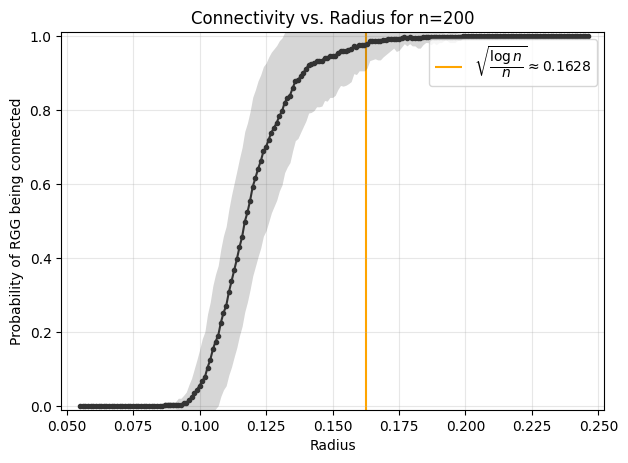

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)


ax.plot(radii, connected_mean, marker=".", color='.2')
ax.fill_between(radii,
                connected_mean-connected_stdv/2,
                connected_mean+connected_stdv/2,
                alpha=0.2, lw=0, color='.2')

ax.vlines(np.sqrt(np.log(n)/n),-1,2, color='orange', zorder=0,
          label=r'$\sqrt{\dfrac{\log n}{n}} \approx %.4f$'%(np.sqrt(np.log(n)/n)))

ax.legend()

ax.set_xlabel("Radius")
ax.set_ylabel("Probability of RGG being connected")
ax.set_title(f"Connectivity vs. Radius for n={n}")

ax.grid(alpha=0.3)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(min(radii)-0.002,max(radii)+0.002)


plt.show()

_____

### Your turn!

Repeatedly generate RGGs with $n=300$, and analyze how the average clustering coefficient changes with radius $r$. Create a plot of clustering coefficient vs. radius.

In [37]:
niter = 50
n = 200
radii = np.logspace(-3, 0.3, 51).round(5)

triangles_mean = []
triangles_stdv = []
cc_mean = []
cc_stdv = []
for ri,r in enumerate(radii):
    if ri%10==0:
        print(np.round(r,5))
    tmp = []
    tmp_cc = []
    for _ in range(niter):
        G = nx.random_geometric_graph(n, r)
        tt = nx.transitivity(G)
        tt = tt if not np.isnan(tt) else 1.0
        tmp.append(tt)
        tmp_cc.append(nx.average_clustering(G))

    triangles_mean.append(np.nanmean(tmp))
    triangles_stdv.append(np.nanstd(tmp))
    cc_mean.append(np.nanmean(tmp_cc))
    cc_stdv.append(np.nanstd(tmp_cc))


# convert to 
triangles_mean = np.array(pd.Series(triangles_mean).rolling(window=3,center=True).mean())
triangles_stdv = np.array(pd.Series(triangles_stdv).rolling(window=3,center=True).mean())

cc_mean = np.array(pd.Series(cc_mean).rolling(window=3,center=True).mean())
cc_stdv = np.array(pd.Series(cc_stdv).rolling(window=3,center=True).mean())

0.001
0.00457
0.02089
0.0955
0.43652
1.99526


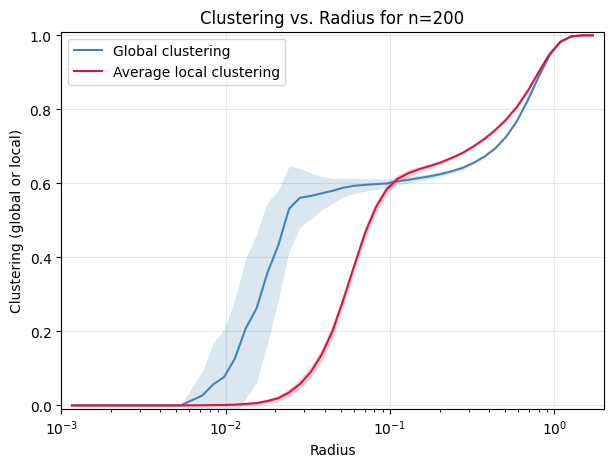

In [40]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)


ax.semilogx(radii, triangles_mean, color='steelblue', label='Global clustering')
ax.fill_between(radii,
                triangles_mean-triangles_stdv/2,
                triangles_mean+triangles_stdv/2,
                alpha=0.2, lw=0, color='steelblue')

ax.semilogx(radii, cc_mean, color='crimson', label='Average local clustering')
ax.fill_between(radii,
                cc_mean-cc_stdv/2,
                cc_mean+cc_stdv/2,
                alpha=0.2, lw=0, color='crimson')


ax.legend()

ax.set_xlabel("Radius")
ax.set_ylabel("Clustering (global or local)")
ax.set_title(f"Clustering vs. Radius for n={n}")

ax.grid(alpha=0.3)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(min(radii),max(radii))


plt.show()

## Open Street Maps NetworkX `OSMnx`

From the [readthedocs](https://osmnx.readthedocs.io/en/stable/): "*OSMnx is a Python package to easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap. You can download and model walking, driving, or biking networks with a single line of code then analyze and visualize them. You can just as easily work with urban amenities/points of interest, building footprints, transit stops, elevation data, street orientations, speed/travel time, and routing.*"

**References:**
1. Boeing, G. (2024). Modeling and Analyzing Urban Networks and Amenities with OSMnx. Working paper. https://geoffboeing.com/publications/osmnx-paper/

In [41]:
import osmnx as ox

ModuleNotFoundError: No module named 'osmnx'

In [ ]:
## random geometric graphs

Lots of good resources here:

https://github.com/mszell/geospatialdatascience/tree/main

In [ ]:
# https://geographicdata.science/book/notebooks/07_local_autocorrelation.html MORAN's I

In [ ]:
# https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html#sphx-glr-auto-examples-geospatial-plot-polygons-py

https://geoffboeing.com/publications/osmnx-paper/

- find the latlon of where you're from, make the street network of 5 miles radius
- with a partner, find a way to quantify the dissimilarities between these two networks
- compare these networks with ER networks

In [ ]:
## phil chodrow information measure

In [ ]:
# use brennan apple watch data and calculate radius of gyration

In [ ]:
# use post office datasets

__________
## Next time...
There is no next time!!
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://asmithh.github.io/network-science-data-book/intro.html
    - Github: https://github.com/asmithh/network-science-data-book
    - Syllabus and course details: https://brennanklein.com/phys7332-fall24
2. Penrose, M. D. (2003). *Random Geometric Graphs.* Oxford University Press. https://doi.org/10.1093/acprof:oso/9780198506263.001.0001
3. Gilbert, E. N. (1961). Random plane networks. *Journal of the Society for Industrial and Applied Mathematics*, 9(4), 533–543. https://doi.org/10.1137/0109045
4. Dall, J., & Christensen, M. (2002). Random geometric graphs. *Physical Review E*, 66(1), 016121. https://doi.org/10.1103/PhysRevE.66.016121
5. Penrose, M. D. (1999). On $k$-connectivity for a geometric random graph. *Random Structures & Algorithms*, 15(2), 145–164. https://doi.org/10.1002/(SICI)1098-2418(199909)15:2%3C145::AID-RSA2%3E3.0.CO;2-G
6. Barthelemy, M. (2011). Spatial networks. *Physics Reports*, 499(1–3), 1–101. https://doi.org/10.1016/j.physrep.2010.11.002
7. Haenggi, M. (2009). *Stochastic Geometry for Wireless Networks.* Cambridge University Press. https://doi.org/10.1017/CBO9781139043816
8. Eppstein, D., Goodrich, M. T., & Trott, L. (2009, November). Going off-road: transversal complexity in road networks. In Proceedings of the 17th *ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems* (pp. 23-32). https://doi.org/10.1145/1653771.1653778